In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as scio
import random

In [2]:
def load_data(path):
    """
    读取数据
    param
    path: 数据路径
    """
    
    train_data = np.array(pd.read_csv(path, header = None, index_col=False));
    data_list = [];
    for index in range(train_data.shape[0]):
        strlist = train_data[index][0].strip().split('    ');
        strlist[0] = strlist[0].split(' ')[1];
        data_list.append(strlist);
    data_list = np.array(data_list);
    data_list = data_list.astype(float);
    return data_list;

In [182]:
def load_data(path):
    """
    读取数据
    param
    path: 数据路径
    
    """
    
    data = scio.loadmat(path);
    train_data = data['X'];
    train_label = data['y'];
    train_label = train_label.reshape(-1);  # 标签转为向量
    return train_data, train_label;

In [211]:
class SVM:
    def __init__(self, train_data, train_label, sigma = 0.1, C = 100, epsilon = 0.0001, iter_time = 30):
        """
        初始化函数
        param
        train_data: 训练集
        train_label: 训练标签
        sigma: 高斯核函数的参数
        C: 软间隔的惩罚系数
        epsilon: 精度
        iter_time: 迭代次数
        """
        
        self.train_data = train_data;  # 训练特征集
        self.train_label = train_label;  # 训练标签
        
        self.sigma = sigma;  # 高斯核函数参数
        self.C = C;  # 惩罚项系数
        self.epsilon = epsilon;  # 精确值
        self.iter_time = iter_time;  # 迭代次数
        
        self.G = np.zeros(train_data.shape[0]);  # G值
        self.E = -1 * train_label.copy();  # E值
        self.alpha = np.zeros(train_data.shape[0]);  # 拉格朗日参数
        self.b = 0;  
        self.m = train_data.shape[0];  # 样本数
        
        self.supportVecIndex = [];  # 支持向量
    
    def gaussian_kernel(self, i):
        """
        高斯核函数,向量化计算K(j,i),即一次性计算出K(1,i), K(2,i),...,K(m,i),m是样本数
        param
        i: 需要计算的那个样本的编号
        return
        K: 是i与每个样本的核函数结果向量
        """
        
        K = np.exp(-1 * np.sum((self.train_data - self.train_data[i])**2, axis = 1) / (2 * self.sigma**2));
        return K;
    
    def single_gaussian_kernel(self, i, j):
        """
        计算单个高斯核函数，不使用向量化，单独计算K(i,j)
        param
        i: 第1个样本编号
        j: 第2个样本编号
        """
        K = np.exp(-1 * np.sum((self.train_data[i] - self.train_data[j])**2) / (2 * (self.sigma ** 2)));
        return K;
    
    def compute_G(self, i):
        """
        计算第i个样本的G值
        param
        i: 计算的那个样本的编号
        """
        
        K_i = self.gaussian_kernel(i);  # 计算这个样本的高斯核函数结果
        G = np.sum(self.alpha * self.train_label * K_i) + self.b;
        return G;
    
    def compute_E(self, i):
        """
        计算第i个样本的E值
        param
        i: 样本的编号
        """
        
        G_i = self.compute_G(i);  # 计算这个样本的G值
        E = G_i - self.train_label[i];
        return E;
    
    def gaussian_kernel_for_test(self, x):
        """
        用于计算预测样本的高斯核函数，使用样本特征作为输入
        param
        x: 输入样本
        return
        K: 预测样本与每个样本的结果向量
        """
        
        K = np.exp(-1 * np.sum((self.train_data - x)**2, axis = 1) / (2 * self.sigma**2));
        return K;
    
    def compute_G_for_test(self, x):
        """
        计算预测样本的G值
        param
        x: 输入样本
        """
        
        K_i = self.gaussian_kernel_for_test(x);  # 计算这个样本的高斯核结果
        G = np.sum(self.alpha * self.train_label * K_i) + self.b;
        return G;
    
    def judge_KKT(self, i):
        """
        判断第i个样本是否满足KKT
        return
        True: 满足KKT条件
        False: 不满足
        """
        
        Ei = self.compute_E(i);
        # 该语句用于判断是否满足3条KTT条件
        if (((self.train_label[i] * Ei < -self.epsilon) and (self.alpha[i] < self.C)) or ((self.train_label[i] * Ei > self.epsilon) and (self.alpha[i] > 0))):
            return False;
        
        return True;
            
    
    def select_second_alpha(self, i):
        """
        选出第二个alpha
        param
        i: 选中的第1个alpha的编号
        return 
        j: 第二个alpha的索引
        """
        
        delta_Es = abs(self.E - self.E[i]);  # 计算第i个样本的E与所有的其他样本的E差
        delta_Es[i] = -1;  # 把与自己的差值设为负的，防止选到自己
        j = np.argmax(delta_Es);
        return j

    
    def update(self, i, j, E1, E2):
        """
        选择好两个alpha后，更新alpha，如果alpha变化太小则直接退出
        parame
        i: 第一个alpha的编号
        j: 第二个alpha的编号
        E1: 第1个alpha样本的E值
        E2: 第2个alpha样本的E值
        return
        True: 成功更新
        False: 未进行更新，返回重新选择alpha
        """
        
        # 计算未经剪辑的alpha2的解
        x1, x2 = self.train_data[i], self.train_data[j];  # 选择的第1个和第2个alpha的样本
        y1, y2 = self.train_label[i], self.train_label[j];  # 选择的第1个和第2个alpha的样本标签
        alpha1, alpha2 = self.alpha[i], self.alpha[j];  # 选择的第1个和第2个alpha
        self.single_gaussian_kernel(i, j)
        K11, K12, K22 = self.single_gaussian_kernel(i, i), self.single_gaussian_kernel(i, j), self.single_gaussian_kernel(j, j);
        eta = K11 + K22 - 2 * K12;           
        alpha2_new_unc = self.alpha[j] + (self.train_label[j] * (E1 - E2) ) / eta;  # 未经剪辑的alpha2的解
        # 剪辑解
        if (y1 == y2):
            L = max(0, alpha1 + alpha2 - self.C);
            H = min(self.C, alpha1 + alpha2);
        else:
            L = max(0, alpha2 - alpha1);
            H = min(self.C, self.C + alpha2 - alpha1);
        if (alpha2_new_unc<=H and alpha2_new_unc>=L):
            alpha2_new = alpha2_new_unc;
        elif (alpha2_new_unc < L):
            alpha2_new = L;
        else:
            alpha2_new = H;     
        if (abs(alpha2_new - alpha2) < 0.00001):  # 如果更新太小，直接return，重新选择
            return False
        alpha1_new = alpha1 + y1 * y2 * (alpha2 - alpha2_new);
        self.alpha[i] = alpha1_new;  # 更新alpha1
        self.alpha[j] = alpha2_new;  # 更新alpha2
        # 更新b
        b1 = -1 * E1 - y1 * K11 * (alpha1_new - alpha1) - y2 * K12 * (alpha2_new - alpha2) + self.b;
        b2 = -1 * E2 - y1 * K12 * (alpha1_new - alpha1) - y2 * K22 * (alpha2_new - alpha2) + self.b;  
        # 确定b
        if (alpha1_new < self.C and alpha1_new > 0):
            self.b = b1;
        elif (alpha2_new < self.C and alpha2_new > 0):
            self.b = b2;
        else:
            self.b = (b1 + b2) / 2;

        self.E[i] = self.compute_E(i);  # 更新E1
        self.E[j] = self.compute_E(j);  # 更新E2
        return True;
    
    def train(self):
        """
        使用SMO算法进行训练
        """
        
        iter_time = 0;  # 当前的循环次数
        entire_flag = True;  # 是否进行整个数据集遍历的标记
        parameterChanged = 1;  # 记录参数改变的次数
        while (iter_time < self.iter_time and parameterChanged > 0 or entire_flag):
            parameterChanged = 0;
            if (entire_flag):
                entire_flag = False;  # 下次对支持向量进行遍历
                for i in range(self.m):  # 遍历每个样本，选择第1个alpha
                    if (not self.judge_KKT(i)):  # 如果这个样本不满足KKT条件，则作为第1个alpha，然后选择第2个alpha
                        self.E[i] = self.compute_E(i);  # 第1个alpha样本的E值
                        j = self.select_second_alpha(i);  # 选择第2个alpha
                        self.E[j] = self.compute_E(j);  # 第2个E值
                        flag = self.update(i, j, self.E[i], self.E[j]); 
                        if (flag == True):
                            parameterChanged += 1;
            else:
                indices_in = [];  # 存放支持向量0<alpha<C的索引
                for i in range(self.m):
                    if (self.alpha[i]>0 and self.alpha[i]<self.C):
                        indices_in.append(i);
                        
                for i in indices_in:  # 对支持向量先进行选择
                    if (not self.judge_KKT(i)):  # 如果这个样本不满足KKT，则作为第1个alpha，然后选择第2个alpha
                        self.E[i] = self.compute_E(i);  # 第1个alpha样本的E值
                        j = self.select_second_alpha(i);  # 选择第2个alpha
                        self.E[j] = self.compute_E(j);  # 第2个E值
                        flag = self.update(i, j, self.E[i], self.E[j]); 
                        if (flag == True):
                            parameterChanged += 1;
                            
                if (parameterChanged == 0):  # 如果参数1个都没改变，则接下来进行整个训练集的遍历，如果参数变了，继续遍历支持向量
                    entire_flag = True;
                    
            iter_time += 1;
            #打印迭代轮数，i值，该迭代轮数修改alpha数目
#             print("iter: %d , pairs changed %d" % (iter_time, parameterChanged))
        #全部计算结束后，重新遍历一遍alpha，查找里面的支持向量
        for i in range(self.m):
            #如果alpha>0，说明是支持向量
            if (self.alpha[i] > 0 and self.alpha[i] < self.C):
                #将支持向量的索引保存起来
                self.supportVecIndex.append(i)

                
    def sign(self, z):
        """
        决策函数，返回类别
        param
        z: 预测值
        """
        if (z >= 0):
            return 1;
        else:
            return -1;
    
    def show_support_vector(self):
        fig, ax = plt.subplots(figsize=(8, 6));
        p = np.array(self.supportVecIndex)[np.where(self.train_label[self.supportVecIndex]==1)[0]];
        n = np.array(self.supportVecIndex)[np.where(self.train_label[self.supportVecIndex]==-1)[0]];
        ax.scatter(self.train_data[p, 0], self.train_data[p, 1],  color='r');
        ax.scatter(self.train_data[n, 0], self.train_data[n, 1],  color='b');
        plt.show();
    
    def show_boundary(self, flag):
        """
        展示决策边界
        param
        flag: 为1则是画出数据集1的决策边界，2则是画出数据集2的决策边界。
              因为数据集2有噪声样本，直接取最大最小值作为边界范围就太大了。
        """
        
        if (flag == 1):
            x_left, x_right = np.min(train_data[:, 0]) - 0.05, np.max(train_data[:, 0]) + 0.05;  # 左右界
            y_low, y_high = np.min(train_data[:, 1]) - 0.05, np.max(train_data[:, 1]) + 0.05;  # 上下界
        elif (flag == 2):  # 
            x_left, x_right = 0, 1.1;  # 左右界
            y_low, y_high = 0.38, 1;  # 上下界
        x = np.linspace(x_left, x_right, 500);  # 按左右界生成序列
        y = np.linspace(y_low, y_high, 500);  # 同上
        xx, yy = np.meshgrid(x, y);  # 生成网格数据
        xx = xx.reshape(-1, 1);  # 拉长
        yy = yy.reshape(-1, 1);
        test_data = np.column_stack((xx, yy));
        zz = [];  # 存放预测类别
        for sample in test_data:
            zz.append(self.sign(self.compute_G_for_test(sample)));  # 把预测类别添加到zz中
        
        zz = np.array(zz);
        p_sample = np.where(zz == 1)[0];
        n_sample = np.where(zz == -1)[0];   
        
        fig, ax = plt.subplots(figsize=(8, 6));
        ax.scatter(test_data[p_sample, 0], test_data[p_sample, 1],  color='r');
        ax.scatter(test_data[n_sample, 0], test_data[n_sample, 1],  color='b');  
        plt.show();


In [151]:
path_train = 'F:\\Anaconda\\path\\base\\Statistical learning\\SVM\\dataset_1';
data1 = scio.loadmat(path_train);
X_train1 = data1['X'];
y_train1 = data1['y'];
y_train1 = y_train1.reshape(-1);

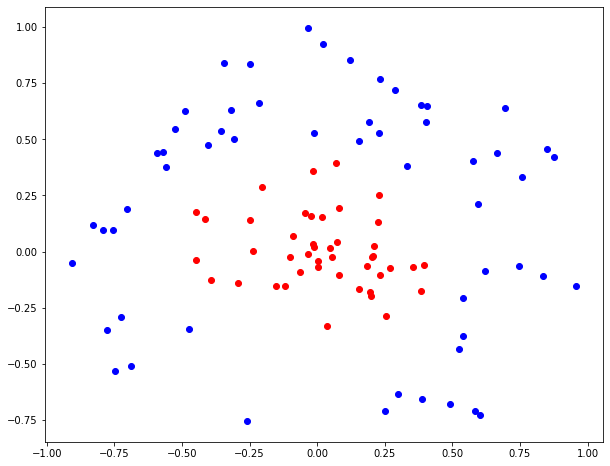

In [159]:
fig, ax = plt.subplots(figsize=(10, 8));
p_sample = np.where(y_train1 == 1)[0];
n_sample = np.where(y_train1 == -1)[0];
ax.scatter(X_train1[p_sample, 0], X_train1[p_sample, 1],  color='r');
ax.scatter(X_train1[n_sample, 0], X_train1[n_sample, 1],  color='b');

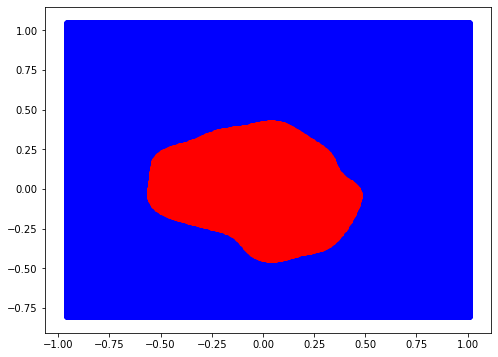

In [192]:
train_data, train_label = load_data('F:\\Anaconda\\path\\base\\Statistical learning\\SVM\\dataset_1');
temp_svm = SVM(train_data, train_label, sigma = 0.1);
temp_svm.train();
temp_svm.show_boundary(1);

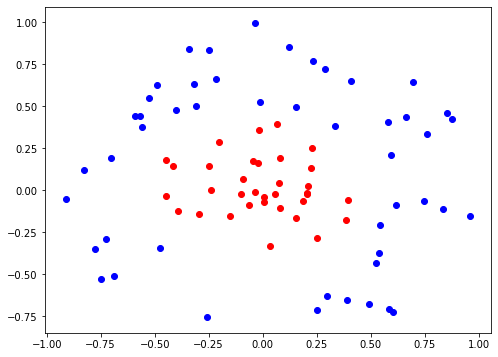

In [193]:
temp_svm.show_support_vector();

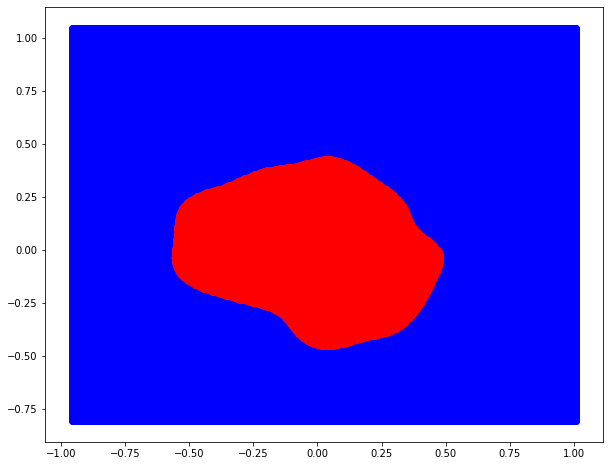

In [163]:
temp_svm.show_boundary(True)

In [212]:
file_name = 'F:\\Anaconda\\path\\base\\Statistical learning\\SVM\\dataset_2';
data1 = scio.loadmat(file_name);
X_train1 = data1['X'];
y_train1 = data1['y'];
y_train1 = y_train1.reshape(-1);
temp_svm1 = SVM(X_train1, y_train1, sigma = 0.1, C = 300);
temp_svm1.train()

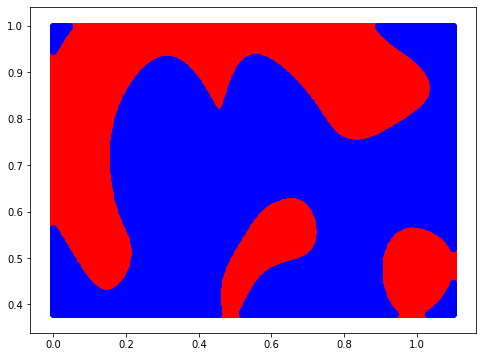

In [210]:
temp_svm1.show_boundary(2)

In [ ]:
temp_svm1.show_support_vector()

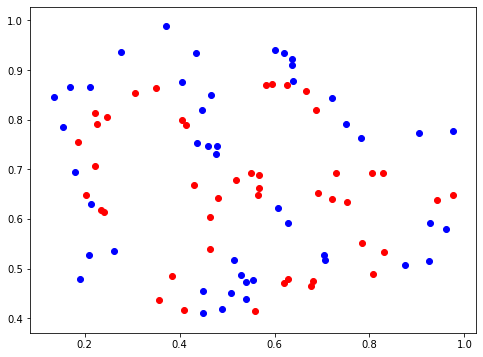

In [180]:
"""
打印支持向量
"""

# print(np.where(y_train1[temp_svm1.supportVecIndex]==1)[0])
# print(np.where(y_train1[temp_svm1.supportVecIndex]==-1)[0])
# print(np.array(temp_svm1.supportVecIndex))
p = np.array(temp_svm1.supportVecIndex)[np.where(y_train1[temp_svm1.supportVecIndex]==1)[0]];
n = np.array(temp_svm1.supportVecIndex)[np.where(y_train1[temp_svm1.supportVecIndex]==-1)[0]];
# print(n)
fig, ax = plt.subplots(figsize=(8,6));
ax.scatter(X_train1[p, 0], X_train1[p, 1],  color='b');
ax.scatter(X_train1[n, 0], X_train1[n, 1],  color='r');

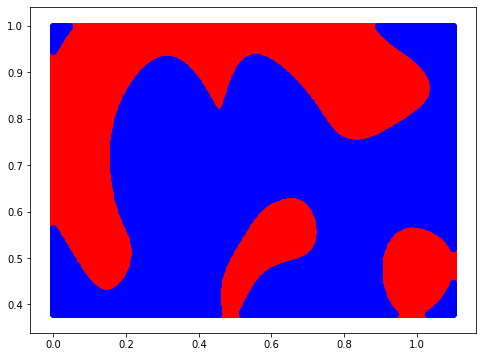

In [197]:
temp_svm1.show_boundary(2)